In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint

import collections
import re

import datetime
import pickle
import dill
import os

import gzip 
from scipy.signal import find_peaks

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:79: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")


# Analysis for new idea: Vaccine timing and outbreak cycles

Begin by developing treatment combinations

In [2]:
dirname = "sims/2023-02-27/"
flist = [dirname + x for x in os.listdir(dirname) if '.pgz' in x]

In [17]:
# Functions for analysis
from scipy.signal import find_peaks

def process_sim(f, print_ = False):
    # Parse beta0 and beta1 from file name
    beta = {s.split("_")[0]: float(s.split("_")[1]) for s in f.split("/")[2].split("__")[0:2]}
    with gzip.open(f, 'rb') as f:
        sim = pickle.load(f)
        
    if print_:
        sim.plot_trajectory()
        plt.show()
        
    vu = np.mean(sim._pop[:,[i for i,x in enumerate(sim._colnames) if x == "vaccine_priority" ][0]] == 0)
    
    ret = {**beta, 
            'T_REINFECTION': sim._params.T_REINFECTION,
              'BOOSTER_DAY': sim._params.BOOSTER_DAY,
              'VEBOOST': sim._params.VEBOOST,
              'VU': vu}
    N = sim.S[0] + sim.E[0]
    threshold = N * 0.01
    threshold= 2
    x = np.add.reduceat(sim.Cc, np.arange(0, len(sim.Cc), 24))
    peaks, properties = find_peaks(x, height=threshold, distance=30, width=7, rel_height=1)
    
    count = []
    n_S = []
    for i in range(len(properties["left_ips"])):
        left_bound = round(properties["left_ips"][i])
        right_bound = round(properties["right_ips"][i])
        count.append(sum(x[left_bound:right_bound]))
        
        # Get the number of susceptibles at left_ips
        n_S.append(sim.S[(left_bound - 1)*24])
            
    ret["num_outbreaks"] = len(peaks)
    ret["mean_time_bw_outbreaks"] = np.mean(np.diff(peaks))
    ret["avg_outbreak_size"] = np.mean(count)/N
    ret["mean_S"] = np.mean(n_S)/N
    
    return ret
    

In [15]:
processed_sims = []
for i, fname in enumerate(flist):
    print(i, end="\r")
    processed_sims.append(process_sim(fname))


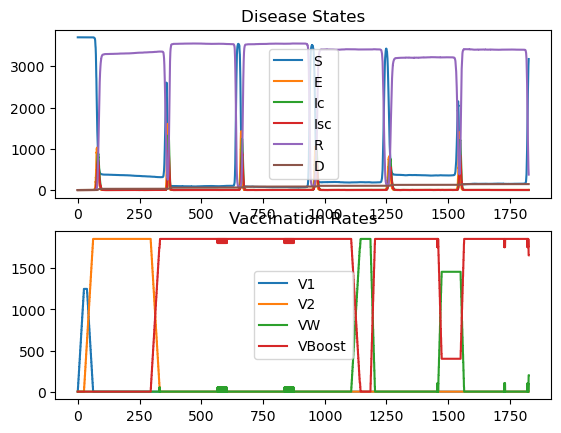

{'BETA0': 0.0868024019101841,
 'BETA1': 0.6180950213178089,
 'T_REINFECTION': 6480,
 'BOOSTER_DAY': 90,
 'VEBOOST': 0.4855318069458008,
 'VU': 0.5020264793299108,
 'num_outbreaks': 6,
 'mean_time_bw_outbreaks': 293.4,
 'avg_outbreak_size': 0.5300819598306764,
 'mean_S': 0.6494190759254256}

In [33]:
process_sim(flist[1412], True)

In [19]:
processed_sims = pd.DataFrame(processed_sims)

In [20]:
# First, aggregate values

print("Number of outbreaks:")
print(np.mean(processed_sims.num_outbreaks))
print(np.quantile(processed_sims.num_outbreaks, [0.05, 0.95]))

print("Time between outbreaks:")
print(np.mean(processed_sims.mean_time_bw_outbreaks))
print(np.quantile(processed_sims.mean_time_bw_outbreaks, [0.05, 0.95]))

print("Outbreaks ize:")
print(np.mean(processed_sims.avg_outbreak_size))
print(np.quantile(processed_sims.avg_outbreak_size, [0.05, 0.95]))

print("Proportion susceptible:")
print(np.mean(processed_sims.mean_S))
print(np.quantile(processed_sims.mean_S, [0.05, 0.95]))

Number of outbreaks:
7.151666666666666
[ 5. 10.]
Time between outbreaks:
281.68502358174237
[183.21666667 400.5125    ]
Outbreaks ize:
0.4863769918073421
[0.24162464 0.66811363]
Proportion susceptible:
0.69436143220491
[0.49292155 0.89054289]


Text(0.5, 0, 'Time until reinfection (days)')

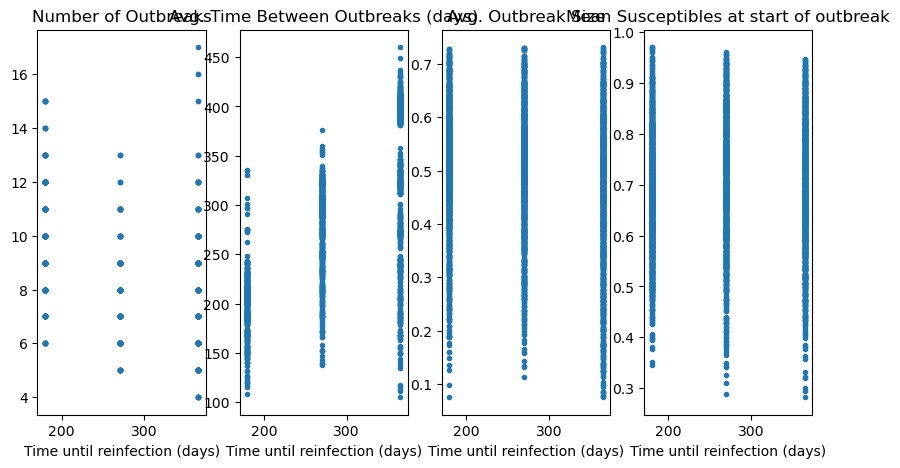

In [21]:
fig, ax = plt.subplots(ncols=4,figsize= (10,5))
ax[0].plot(processed_sims.T_REINFECTION/24, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Time until reinfection (days)")
ax[1].plot(processed_sims.T_REINFECTION/24, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Time until reinfection (days)")
ax[2].plot(processed_sims.T_REINFECTION/24, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Time until reinfection (days)")
ax[3].plot(processed_sims.T_REINFECTION/24, processed_sims.mean_S, ".")
ax[3].set_title("Mean Susceptibles at start of outbreak")
ax[3].set_xlabel("Time until reinfection (days)")

In [22]:
processed_sims.groupby(["T_REINFECTION"]).agg(np.mean)

,BETA0,BETA1,BOOSTER_DAY,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size,mean_S
T_REINFECTION,,,,,,,,,
4320,0.059999,0.499865,128.75,0.567586,0.499555,9.190000,203.467573,0.505547,0.683809
6480,0.059999,0.499865,128.75,0.567586,0.499878,6.503333,286.892289,0.497885,0.707448
8760,0.059999,0.499865,128.75,0.567586,0.499643,5.761667,354.695208,0.455699,0.691828


Text(0.5, 0, 'Time until reinfection (days)')

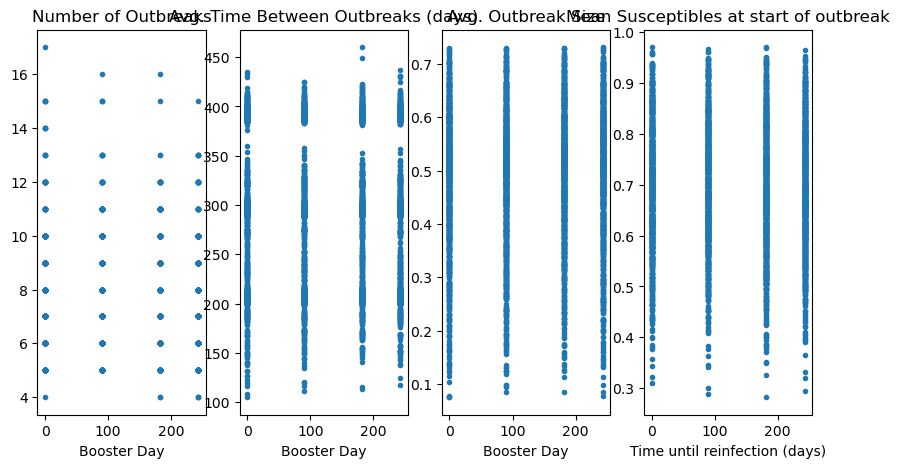

In [23]:
fig, ax = plt.subplots(ncols=4,figsize= (10,5))
ax[0].plot(processed_sims.BOOSTER_DAY, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Booster Day")
ax[1].plot(processed_sims.BOOSTER_DAY, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Booster Day")
ax[2].plot(processed_sims.BOOSTER_DAY, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Booster Day")
ax[3].plot(processed_sims.BOOSTER_DAY, processed_sims.mean_S, ".")
ax[3].set_title("Mean Susceptibles at start of outbreak")
ax[3].set_xlabel("Time until reinfection (days)")

In [24]:
processed_sims.groupby(["BOOSTER_DAY"]).agg(np.mean)

,BETA0,BETA1,T_REINFECTION,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size,mean_S
BOOSTER_DAY,,,,,,,,,
0,0.059999,0.499865,6520.0,0.567586,0.499285,7.178889,281.903380,0.482085,0.698894
90,0.059999,0.499865,6520.0,0.567586,0.499830,7.201111,280.358717,0.481058,0.696332
182,0.059999,0.499865,6520.0,0.567586,0.499847,7.095556,283.112966,0.491719,0.690075
243,0.059999,0.499865,6520.0,0.567586,0.499805,7.131111,281.365032,0.490646,0.692145


Text(0.5, 0, 'Vaccine Uptake Rate')

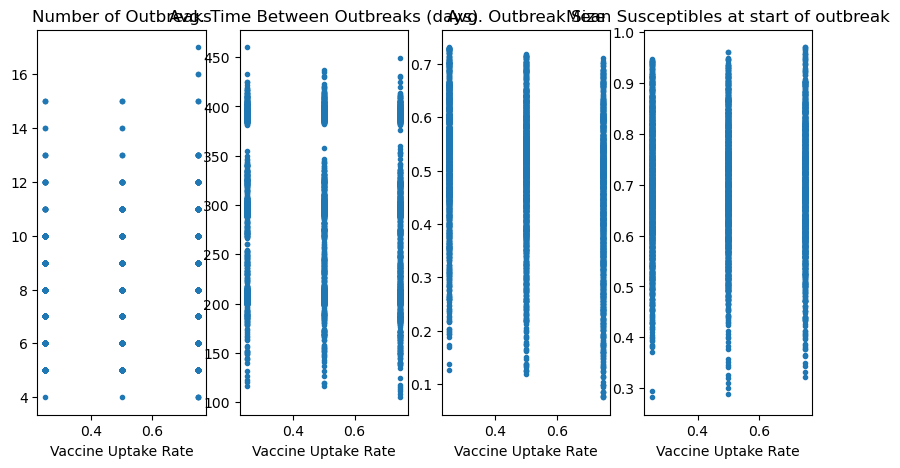

In [25]:
def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]

processed_sims["VU_rounded"] = [closest_value([0.25, 0.5, 0.75], x) for x in processed_sims.VU]

fig, ax = plt.subplots(ncols=4,figsize= (10,5))
ax[0].plot(processed_sims.VU_rounded, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Vaccine Uptake Rate")
ax[1].plot(processed_sims.VU_rounded, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Vaccine Uptake Rate")
ax[2].plot(processed_sims.VU_rounded, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Vaccine Uptake Rate")

ax[3].plot(processed_sims.VU_rounded, processed_sims.mean_S, ".")
ax[3].set_title("Mean Susceptibles at start of outbreak")
ax[3].set_xlabel("Vaccine Uptake Rate")

In [26]:
processed_sims.groupby(["VU_rounded"]).agg(np.mean)

,BETA0,BETA1,T_REINFECTION,BOOSTER_DAY,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size,mean_S
VU_rounded,,,,,,,,,,
0.25,0.059999,0.499865,6520.0,128.75,0.567586,0.249792,7.026667,288.080104,0.522504,0.695273
0.50,0.059999,0.499865,6520.0,128.75,0.567586,0.499417,7.115833,283.885442,0.489777,0.693492
0.75,0.059999,0.499865,6520.0,128.75,0.567586,0.749867,7.312500,273.089525,0.446850,0.694319


Text(0.5, 0, 'BETA_1')

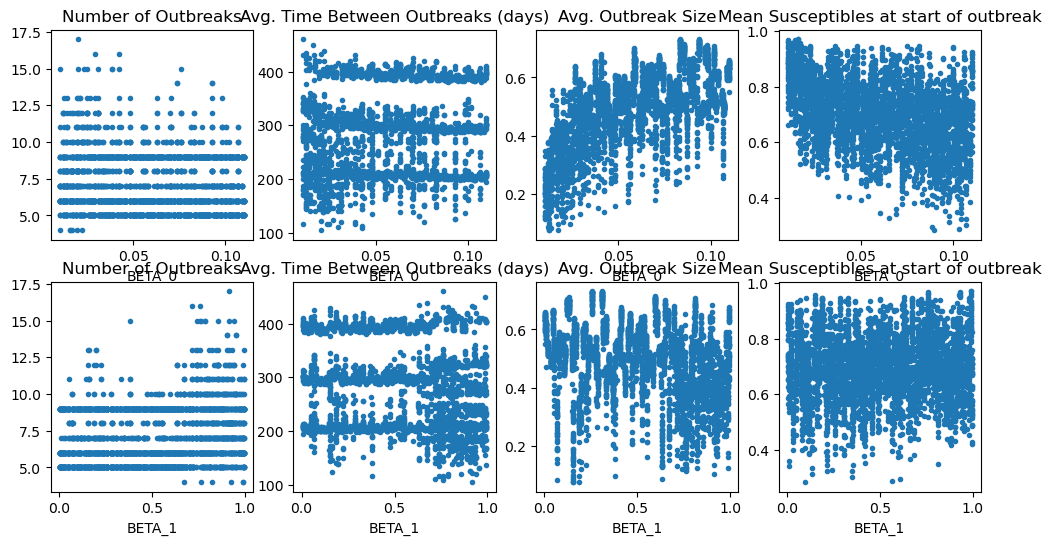

In [27]:
fig, ax = plt.subplots(ncols=4, nrows =2, figsize= (12,6))
ax[0,0].plot(processed_sims.BETA0, processed_sims.num_outbreaks, ".", )
ax[0,0].set_title("Number of Outbreaks")
ax[0,0].set_xlabel("BETA_0")
ax[0,1].plot(processed_sims.BETA0, processed_sims.mean_time_bw_outbreaks, ".")
ax[0,1].set_title("Avg. Time Between Outbreaks (days)")
ax[0,1].set_xlabel("BETA_0")
ax[0,2].plot(processed_sims.BETA0, processed_sims.avg_outbreak_size, ".")
ax[0,2].set_title("Avg. Outbreak Size")
ax[0,2].set_xlabel("BETA_0")
ax[0,3].plot(processed_sims.BETA0, processed_sims.mean_S, ".")
ax[0,3].set_title("Mean Susceptibles at start of outbreak")
ax[0,3].set_xlabel("BETA_0")


ax[1,0].plot(processed_sims.BETA1, processed_sims.num_outbreaks, ".", )
ax[1,0].set_title("Number of Outbreaks")
ax[1,0].set_xlabel("BETA_1")
ax[1,1].plot(processed_sims.BETA1, processed_sims.mean_time_bw_outbreaks, ".")
ax[1,1].set_title("Avg. Time Between Outbreaks (days)")
ax[1,1].set_xlabel("BETA_1")
ax[1,2].plot(processed_sims.BETA1, processed_sims.avg_outbreak_size, ".")
ax[1,2].set_title("Avg. Outbreak Size")
ax[1,2].set_xlabel("BETA_1")
ax[1,3].plot(processed_sims.BETA1, processed_sims.mean_S, ".")
ax[1,3].set_title("Mean Susceptibles at start of outbreak")
ax[1,3].set_xlabel("BETA_1")

# Treatment Effects

In [28]:
# 100 sets of random parameters are drawn
# and repeated for each treatment combination.

# Determine the rep_number from beta0

rep_lookup = {x: i for i, x in enumerate(np.unique(processed_sims.BETA0))}
processed_sims['rep'] = [rep_lookup[b0] for b0 in processed_sims.BETA0]

In [30]:
# ATE of Booster Day
def ATE_booster(processed_sims, bd1, bd0):
    TE = []
    for i in rep_lookup.values():
        for j in np.unique(processed_sims.T_REINFECTION):
            for k in np.unique(processed_sims.VU_rounded):
                t1 = processed_sims.query("rep == " + str(i) + 
                                          " & T_REINFECTION == " + str(j) + 
                                          " & VU_rounded == " + str(k) + 
                                          " & BOOSTER_DAY == " + str(bd1))[
                    ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size", "mean_S"]
                ]
                t0 = processed_sims.query("rep == " + str(i) + 
                                          " & T_REINFECTION == " + str(j) + 
                                          " & VU_rounded == " + str(k) + 
                                          " & BOOSTER_DAY == " + str(bd0))[
                    ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size", "mean_S"]
                ]

                TE.append(t1.iloc[0]-t0.iloc[0])


    print("Vaccinating at day", bd1, "instead of", bd0,"changes", 
         "number of outbreaks by", np.mean([x.num_outbreaks for x in TE]),
         "time between outbreaks by", np.mean([x.mean_time_bw_outbreaks for x in TE]),
         "avg_outbreak_size", np.mean([x.avg_outbreak_size for x in TE]),
         "mean_S ", np.mean([x.mean_S for x in TE])
         )
vec = np.unique(processed_sims.BOOSTER_DAY)
ATE_booster(processed_sims, vec[3], vec[2])
ATE_booster(processed_sims, vec[2], vec[1])
ATE_booster(processed_sims, vec[1], vec[0])

Vaccinating at day 243 instead of 182 changes number of outbreaks by 0.035555555555555556 time between outbreaks by -1.7479337421837418 avg_outbreak_size -0.0010727880469917597 mean_S  0.0020695299662007428
Vaccinating at day 182 instead of 90 changes number of outbreaks by -0.10555555555555556 time between outbreaks by 2.7542489979156644 avg_outbreak_size 0.010661174019146083 mean_S  -0.006257317357443963
Vaccinating at day 90 instead of 0 changes number of outbreaks by 0.022222222222222223 time between outbreaks by -1.5446628294544955 avg_outbreak_size -0.0010272545542424686 mean_S  -0.0025611753602216994


In [34]:
# ATE of reinfection
def ATE_reinf(processed_sims, tr1, tr0):
    TE = []
    for i in rep_lookup.values():
        for j in np.unique(processed_sims.BOOSTER_DAY):
            for k in np.unique(processed_sims.VU_rounded):
                t1 = processed_sims.query("rep == " + str(i) + 
                                          " & T_REINFECTION == " + str(tr1) + 
                                          " & VU_rounded == " + str(k) + 
                                          " & BOOSTER_DAY == " + str(j))[
                    ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size", "mean_S"]
                ]
                t0 = processed_sims.query("rep == " + str(i) + 
                                          " & T_REINFECTION == " + str(tr0) + 
                                          " & VU_rounded == " + str(k) + 
                                          " & BOOSTER_DAY == " + str(j))[
                    ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size", "mean_S"]
                ]

                TE.append(t1.iloc[0]-t0.iloc[0])


    print("When immunity wanes after ", tr1 , "instead of", tr0,
         "number of outbreaks by", np.mean([x.num_outbreaks for x in TE]),
         "time between outbreaks by", np.mean([x.mean_time_bw_outbreaks for x in TE]),
         "avg_outbreak_size", np.mean([x.avg_outbreak_size for x in TE]),
         "mean_S ", np.mean([x.mean_S for x in TE])
         )

vec = np.unique(processed_sims.T_REINFECTION)
ATE_reinf(processed_sims, vec[2], vec[1])
ATE_reinf(processed_sims, vec[1], vec[0])
ATE_reinf(processed_sims, vec[2], vec[0])

When immunity wanes after  8760 instead of 6480 number of outbreaks by -0.7416666666666667 time between outbreaks by 67.80291950757577 avg_outbreak_size -0.042185777964531955 mean_S  -0.01562035251908746
When immunity wanes after  6480 instead of 4320 number of outbreaks by -2.6866666666666665 time between outbreaks by 83.42471564546564 avg_outbreak_size -0.0076614943385935495 mean_S  0.023639118388938746
When immunity wanes after  8760 instead of 4320 number of outbreaks by -3.4283333333333332 time between outbreaks by 151.2276351530414 avg_outbreak_size -0.049847272303125495 mean_S  0.008018765869851287


# Regression Modeling

In [36]:
# ANOVA of treatments on the outcomes
from statsmodels.formula.api import ols 
import statsmodels.api as sm

                   df       sum_sq      mean_sq            F        PR(>F)
T_REINFECTION     1.0  6978.479065  6978.479065  4105.997293  0.000000e+00
BOOSTER_DAY       1.0     3.066118     3.066118     1.804042  1.793094e-01
VEBOOST           1.0    38.608169    38.608169    22.716274  1.952061e-06
VU                1.0    49.039381    49.039381    28.853789  8.300652e-08
Residual       3595.0  6109.997267     1.699582          NaN           NaN


In [41]:
result = ols(formula="avg_outbreak_size ~ BETA0", data=processed_sims).fit()
print(result.summary())
print(result.predict({"BETA0": [0.01, .1]}))
result = ols(formula="mean_S~ BETA0", data=processed_sims).fit()
print(result.summary())
print(result.predict({"BETA0": [0.01, .1]}))

                            OLS Regression Results                            
Dep. Variable:      avg_outbreak_size   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     2020.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:38:57   Log-Likelihood:                 3142.9
No. Observations:                3600   AIC:                            -6282.
Df Residuals:                    3598   BIC:                            -6269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3290      0.004     84.677      0.0

In [37]:
# Interaction with Beta0 and Booster Day
result = ols(formula="avg_outbreak_size ~ BETA0 + BETA1", data=processed_sims).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_outbreak_size   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     1264.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:36:49   Log-Likelihood:                 3299.0
No. Observations:                3600   AIC:                            -6592.
Df Residuals:                    3597   BIC:                            -6573.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3826      0.005     80.380      0.0

# Calculating Average Treatment Effect

6 treatment variables: BETA0, BETA1, T_REINFECTION, VEBOOST, VU_rounded, BOOSTER_DAY

3 outcome variables: num_outbreaks, mean_time_bw_outbreaks, avg_outbreak_size


In [ ]:
processed_sims.groupby(["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "BOOSTER_DAY", "VU_rounded"]).agg(np.mean)

In [ ]:
np.mean(processed_sims[processed_sims.BETA1 > 0.5].avg_outbreak_size)
np.mean(processed_sims[processed_sims.BETA1 < 0.5].avg_outbreak_size)

## Booster Day

In [ ]:
# Let's start with one easy one. BOOSTER_DAY = march 1st (day 59) vs sept 1st (243)
booster_day_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])
booster_day_df

In [ ]:
for i in range(1, 12):
    m1 = booster_day_df.avg_outbreak_size.columns[i]
    m0 = booster_day_df.avg_outbreak_size.columns[i-1]
    
    mte = np.mean(booster_day_df["avg_outbreak_size"][m1] - booster_day_df["avg_outbreak_size"][m0])
    mte = np.mean(booster_day_df["mean_time_bw_outbreaks"][m1] - booster_day_df["mean_time_bw_outbreaks"][m0])
    mte = np.mean(booster_day_df["num_outbreaks"][m1] - booster_day_df["num_outbreaks"][m0])
    
    print(mte)

## Vaccine uptake

In [ ]:
vu_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "BOOSTER_DAY"],
    columns = "VU_rounded",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])
vu_df

In [ ]:
fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]

for i, o in enumerate(outcomes):
    v25 = []
    v50 = []
    v75 = []
    b0_vec = vu_df[o].index.levels[0]
    for b0 in b0_vec:

        v25.append(np.mean(vu_df[o][0.25].loc[b0]))
        v50.append(np.mean(vu_df[o][0.50].loc[b0]))
        v75.append(np.mean(vu_df[o][0.75].loc[b0]))

    ax[i].plot(b0_vec, v25, "--go", label = "25% Vaccine Uptake")
    ax[i].plot(b0_vec, v50, "--bo", label = "50% Vaccine Uptake")
    ax[i].plot(b0_vec, v75, "--ro", label = "75% Vaccine Uptake")
    
    
ax[0].legend()
    
# ax[0].set_title("Higher Vaccine Uptake reduces outbreak size at all transmission probabilities")
ax[0].set_xlabel("Average Probability of Transmission")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Average Probability of Transmission")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Average Probability of Transmission")
ax[2].set_ylabel("Average Number of Outbreaks")
#ax[0].set_ylabel("Average Clinical Infections per Outbreak")

plt.suptitle("Higher Vaccine Uptake reduces outbreak size, but increases frequency")
plt.show()


In [ ]:
fig, ax = plt.subplots()

v25 = []
v50 = []
v75 = []
b1_vec = vu_df["avg_outbreak_size"].index.levels[1]
for b1 in b1_vec:
    
    v25.append(np.mean(vu_df["avg_outbreak_size"][0.25].loc[:, b1]))
    v50.append(np.mean(vu_df["avg_outbreak_size"][0.50].loc[:, b1]))
    v75.append(np.mean(vu_df["avg_outbreak_size"][0.75].loc[:, b1]))
    
ax.plot(b1_vec, v25, "--go", label = "25% Vaccine Uptake")
ax.plot(b1_vec, v50, "--bo", label = "50% Vaccine Uptake")
ax.plot(b1_vec, v75, "--ro", label = "75% Vaccine Uptake")
ax.legend()
ax.set_title("Higher Vaccine Uptake reduces outbreak size at all forcing amplitudes")
ax.set_xlabel("Amplitude of Seasonal Forcing")
ax.set_ylabel("Average Clinical Infections per Outbreak")
    
plt.show()



# Month of Vaccination

In [ ]:
bd_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])

fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]
months = bd_df["num_outbreaks"].columns

for i, o in enumerate(outcomes):
    df = pd.DataFrame(columns = months)
    b0_vec = bd_df[o].index.levels[0]
    for b0 in b0_vec:
        tmp = pd.DataFrame([{k: np.mean(bd_df[o][k].loc[b0]) for k in months}])
        df = pd.concat([df, tmp], ignore_index=True)

    for m in months:
        ax[i].plot(b0_vec, df.loc[:,m], "--o", label = m)
    
    
ax[0].legend()
    
ax[0].set_xlabel("Average Probability of Transmission")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Average Probability of Transmission")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Average Probability of Transmission")
ax[2].set_ylabel("Average Number of Outbreaks")

plt.suptitle("No obvious effect of Month of Vaccination on outcomes across b0")
plt.show()


In [ ]:
bd_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])

fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]
months = bd_df["num_outbreaks"].columns

for i, o in enumerate(outcomes):
    df = pd.DataFrame(columns = months)
    b1_vec = bd_df[o].index.levels[1]
    for b1 in b1_vec:
        tmp = pd.DataFrame([{k: np.mean(bd_df[o][k].loc[:,b1]) for k in months}])
        df = pd.concat([df, tmp], ignore_index=True)

    for m in months:
        ax[i].plot(b1_vec, df.loc[:,m], "--o", label = m)
    
    
ax[0].legend()
    
ax[0].set_xlabel("Amplitude of Seasonal Forcing")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Amplitude of Seasonal Forcing")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Amplitude of Seasonal Forcing")
ax[2].set_ylabel("Average Number of Outbreaks")

plt.suptitle("No obvious effect of Month of Vaccination on outcomes across b0")
plt.show()


## Month of vaccination with t_reinf

In [ ]:
bd_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])

fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]
months = bd_df["num_outbreaks"].columns

for i, o in enumerate(outcomes):
    df = pd.DataFrame(columns = months)
    t_vec = bd_df[o].index.levels[2]
    for t in t_vec:
        tmp = pd.DataFrame([{k: np.mean(bd_df[o][k].loc[:,:,t]) for k in months}])
        df = pd.concat([df, tmp], ignore_index=True)

    for m in months:
        ax[i].plot(t_vec, df.loc[:,m], "--o", label = m)
    
    
ax[0].legend()
    
ax[0].set_xlabel("Amplitude of Seasonal Forcing")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Amplitude of Seasonal Forcing")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Amplitude of Seasonal Forcing")
ax[2].set_ylabel("Average Number of Outbreaks")

plt.suptitle("No obvious effect of Month of Vaccination on outcomes across b0")
plt.show()


# How does transmission affect?

In [ ]:
import seaborn as sns

In [ ]:
# To do this, group simulations by transmission parameters

# processed_sims.groupby(["BETA0", "BETA1"])
arr = processed_sims[processed_sims.BOOSTER_DAY == 31][["BETA0", "BETA1", "avg_outbreak_size"]]
print(arr)
#arr.pivot("BETA0", "BETA1", "avg_outbreak_size")
#sns.heatmap(data=arr, x="BETA0", y="BETA1", hue="avg_outbreak_size")

In [ ]:
import statsmodels.api as sm

In [ ]:
model = OLS(processed_sims["avg_outbreak_size"],
               processed_sims[["BETA0", "BETA1", "BOOSTER_DAY","T_REINFECTION", "VEBOOST", "VU_rounded"]]).fit()

print(model.summary())

model = OLS(processed_sims["mean_time_bw_outbreaks"],
               processed_sims[["BETA0", "BETA1", "BOOSTER_DAY","T_REINFECTION", "VEBOOST", "VU_rounded"]]).fit()

print(model.summary())

model = OLS(processed_sims["num_outbreaks"],
               processed_sims[["BETA0", "BETA1", "BOOSTER_DAY","T_REINFECTION", "VEBOOST", "VU_rounded"]]).fit()

print(model.summary())

In [ ]:
booster_day_df["avg_outbreak_size"].loc[:,0,:,:]